<a href="https://colab.research.google.com/github/deathvadeR-afk/mini_Supervised_Unsupervised_Deep_Learning_GenAI_projects/blob/main/ChestXRay_generation_with_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
import os
import sys
import shutil
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


This notebook uses Generative Adversarial Networks (GANs) to generate synthetic pneumonia-positive X-ray images. The goal is to generate hyperrealistic images that can be used to augment the existing dataset for better model training. The current demo has yet to achieve this goal, but the plan is to explore the application of Generative Adversarial Networks (GANs) to generate new and accurate medical images in the future.

**The primary aim is to train the GAN to generate highly realistic synthetic X-ray images that closely resemble the real ones in the dataset. These synthetic images can then be utilized for future data augmentation.**

As of the current demonstration, the generated images might not yet reach clinically accurate levels. However, **a more complex architecture has the potential to generate highly realistic and accurate pneumonia-positive X-ray images.** The synthetic images produced can effectively augment existing datasets of pneumonia-positive X-rays, leading to improved accuracy and performance of pneumonia detection models

The main takeaway from this project is the potential of GANs in medical image generation for data augmentation, enabling the development of more effective diagnostic tools for pneumonia and other medical conditions.


# Configuration Details:

* GPU Accelerator: T4 (2 units)
* Dataset: **[Chest X-ray Pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)**
* Dataset Size: 3875
* Output Image Size: 512x512
* Optimizer: Adam
* Learning Rate: 0.0002
* Loss Function: Binary Crossentropy
* Generator: 1 Dense, 6 Convolutional Transpose, 1 Convolutional
* Discriminator: 4 Convolutional, 4 MaxPooling, 1 Flatten, 2 Dense

# Import

In [116]:
import os
import time
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, BatchNormalization, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Flatten, MaxPooling2D, Dropout, Reshape

# GPU Initialization

In [117]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 1


# Initialization

In [118]:
BUFFER_SIZE = 64000
BATCH_SIZE = 8
batch_size = BATCH_SIZE
EPOCHS = 50
latent_dim = 128
input_size = [256, 256, 3]
image_size = (256, 256)

# Data Preprocessing

In [119]:
#Creating dataset with ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
)

image_directory = '/kaggle/input/chest-xray-pneumonia/chest_xray'

dataset= datagen.flow_from_directory(
    os.path.join(image_directory, 'train'),
    classes=['PNEUMONIA'],
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)


Found 3875 images belonging to 1 classes.


In [120]:
len(dataset)

485

# Generator Model

In [121]:
def gen_model():
    model = Sequential([
        Input(shape = (latent_dim,)),
        Dense(8*8*256),
        Reshape((8, 8, 256)),
        Conv2DTranspose(512, kernel_size = 4, strides = 2, padding = 'same'),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(32, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2D(3, kernel_size =4, padding = 'same', activation = 'sigmoid')
    ],
        name = "generator"
    )
    return model

# Discriminator Model

In [122]:
from tensorflow.keras.layers import InputLayer # Import InputLayer

def disc_model():
    model = Sequential([
        InputLayer(input_shape=input_size),
        Conv2D(256, kernel_size = 4, strides= 2, padding = 'same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(strides = 2),
        Conv2D(256*2, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(strides=2),
        Conv2D(256*3, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(strides=2),
        Conv2D(256*4, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(strides=2),

        Flatten(),
        Dense(1024),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        Dense(1, activation = 'sigmoid')
    ],
        name = "discriminator"
    )
    return model

In [123]:
generator = gen_model()
discriminator = disc_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [124]:
generator.summary()
discriminator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_42             │ (None, 16, 16, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_77 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_43             │ (None, 32, 32, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_78 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_44             │ (None, 64, 64, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_79 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_45             │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_80 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_46             │ (None, 256, 256, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_81 (LeakyReLU)      │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 256, 256, 3)    │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,998,499 (26.70 MB)

 Trainable params: 6,998,499 (26.70 MB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 128, 128, 256)  │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128, 128, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_82 (LeakyReLU)      │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_83 (LeakyReLU)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 8, 8, 768)      │     6,292,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 8, 8, 768)      │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_84 (LeakyReLU)      │ (None, 8, 8, 768)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 4, 4, 768)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 2, 2, 1024)     │    12,583,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 2, 2, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_85 (LeakyReLU)      │ (None, 2, 2, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_86 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,047,233 (84.10 MB)

 Trainable params: 22,042,113 (84.08 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [125]:
# Helper funtion to help load images in batches
def image_loader(generator):
    for images, labels in generator:
        yield images, labels

# GAN with Custom Traning Step

In [126]:
# GAN model with custom gradient calculation
class Gan(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, disc_opt, gen_opt, loss_function):
        super().compile()
        self.disc_opt = disc_opt
        self.gen_opt = gen_opt
        self.loss_function = loss_function
        self.disc_loss_metric = tf.keras.metrics.Mean(name = "disc_loss")
        self.gen_loss_metric = tf.keras.metrics.Mean(name = "gen_loss")

    @property
    def metrics(self):
        return [self.disc_loss_metric, self.gen_loss_metric]

    # Add a call method to explicitly build the model
    def call(self, inputs):
        # This method is not used during custom training in train_step,
        # but is required by Keras to build the model.
        # We can pass a dummy input through the generator and discriminator
        # to ensure they are built.
        random_latent_vectors = tf.random.normal(shape=(tf.shape(inputs)[0], self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        discriminator_output = self.discriminator(generated_images)
        return discriminator_output # Return something, though the output isn't used

    # Custom training step
    def train_step(self, data):  # Modify the function to accept labels separately
        real_images, real_labels = data
        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Fake image decoding
        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Concatenate the real and fake labels
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )


        labels += 0.05*tf.random.uniform(tf.shape(labels))


        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            disc_loss = self.loss_function(labels, predictions)

        grads  = tape.gradient(disc_loss, self.discriminator.trainable_weights)
        self.disc_opt.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )


        random_latent_vectors = tf.random.normal(shape = (batch_size,self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))


        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))

            gen_loss = self.loss_function(misleading_labels, predictions)

        grads = tape.gradient(gen_loss, self.generator.trainable_weights)
        self.gen_opt.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.disc_loss_metric.update_state(disc_loss)
        self.gen_loss_metric.update_state(gen_loss)
        return{
            "disc_loss": self.disc_loss_metric.result(),
            "gen_loss": self.gen_loss_metric.result()
        }

In [127]:
# Helper function to generate a image using current generator model
def gen_images(current_epoch):
    noise = tf.random.normal([2, latent_dim])
    num_of_sample = 2
    generated_images = generator(noise, training = False)
    figure = plt.figure(figsize=(20,20))
    for i in range(generated_images.shape[0]):
        plt.subplot(2, 2,i+1)
        plt.imshow(generated_images[i, :, :, 0, ], cmap = 'gray')
        plt.title(f"After epoch {current_epoch}")
        plt.axis('off')
    plt.savefig('After epochs{:04d}.png'.format(current_epoch))
    plt.show()

# Callbacks

In [128]:
# We are showing progress of GAN and also saving samples after each epochs
class Gan_Callback(tf.keras.callbacks.Callback):
    def __init__(self, num_images=2, latent_dim = 128):
        self.num_images = num_images
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs =None):
        latent_vectors = tf.random.normal(shape = (self.num_images, latent_dim))
        generated_images = self.model.generator(latent_vectors)
        generated_images *=255
        generated_images.numpy()
        figure = plt.figure(figsize=(10,10))
        for i in range(generated_images.shape[0]):
            plt.subplot(2, 2,i+1)
            plt.imshow(generated_images[i, :, :, 0, ], cmap='gray')
            plt.title(f"After epoch {epoch+1}")
            plt.axis('off')
        plt.savefig('After epochs{:04d}.png'.format(epoch+1))
        plt.show()
        if(epoch % 10 ==0):
            self.model.generator.save('/kaggle/working/gen.h5')
            self.model.discriminator.save('/kaggle/working/disc.h5')

In [129]:
# with strategy.scope(): # Removed MirroredStrategy scope
gan = Gan(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    disc_opt=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    gen_opt=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE),
)

# Training

Epoch 51/60
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - disc_loss: 0.1238 - gen_loss: 28.4998

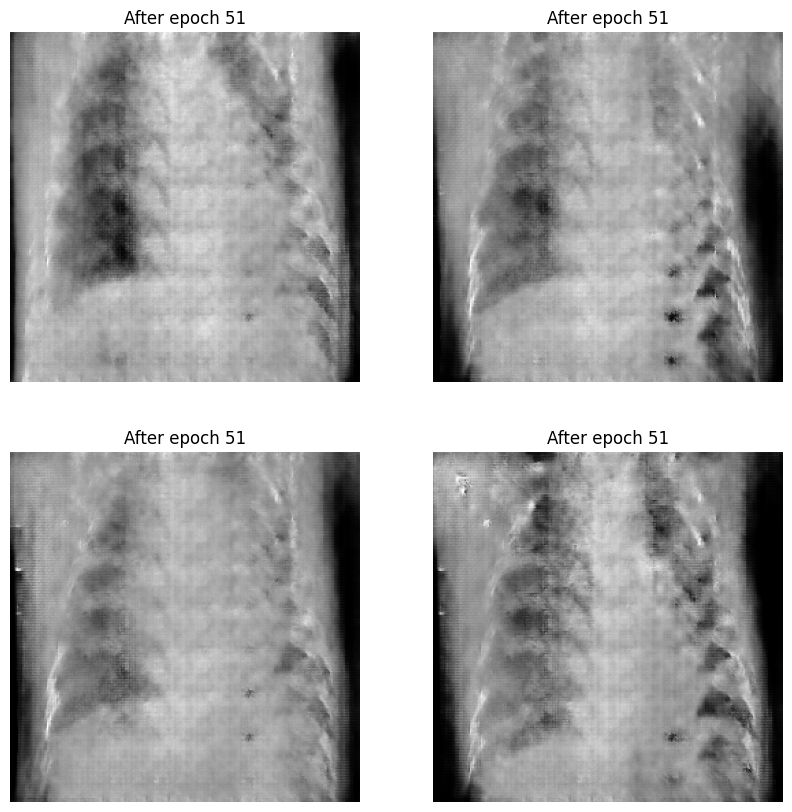

485/485 ━━━━━━━━━━━━━━━━━━━━ 109s 225ms/step - disc_loss: 0.1238 - gen_loss: 28.5025
Epoch 52/60
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - disc_loss: -0.0359 - gen_loss: 86.6845

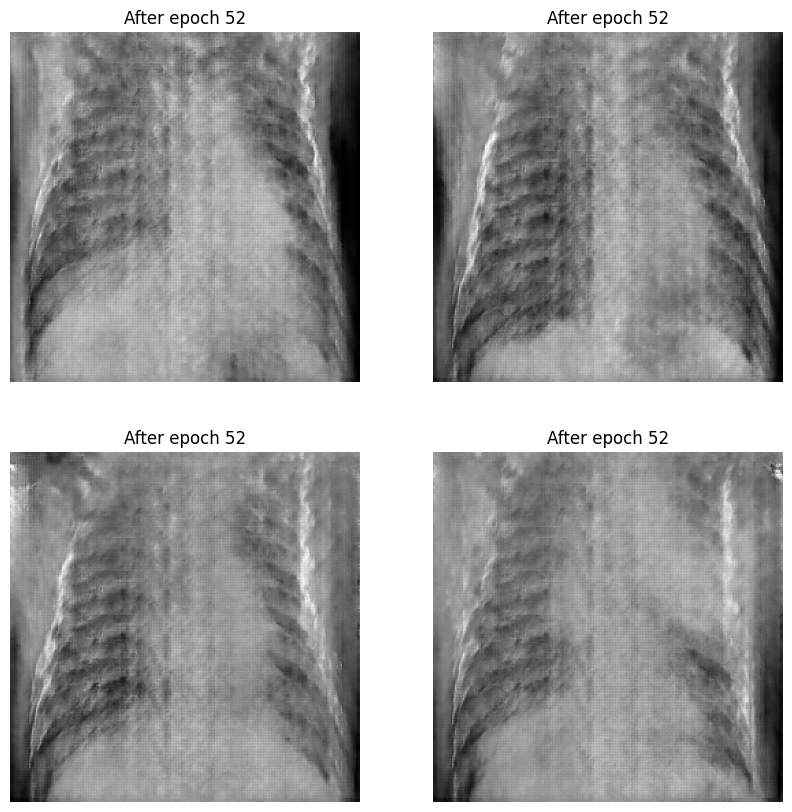

485/485 ━━━━━━━━━━━━━━━━━━━━ 109s 225ms/step - disc_loss: -0.0358 - gen_loss: 86.6354
Epoch 53/60
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - disc_loss: 0.0754 - gen_loss: 29.9992

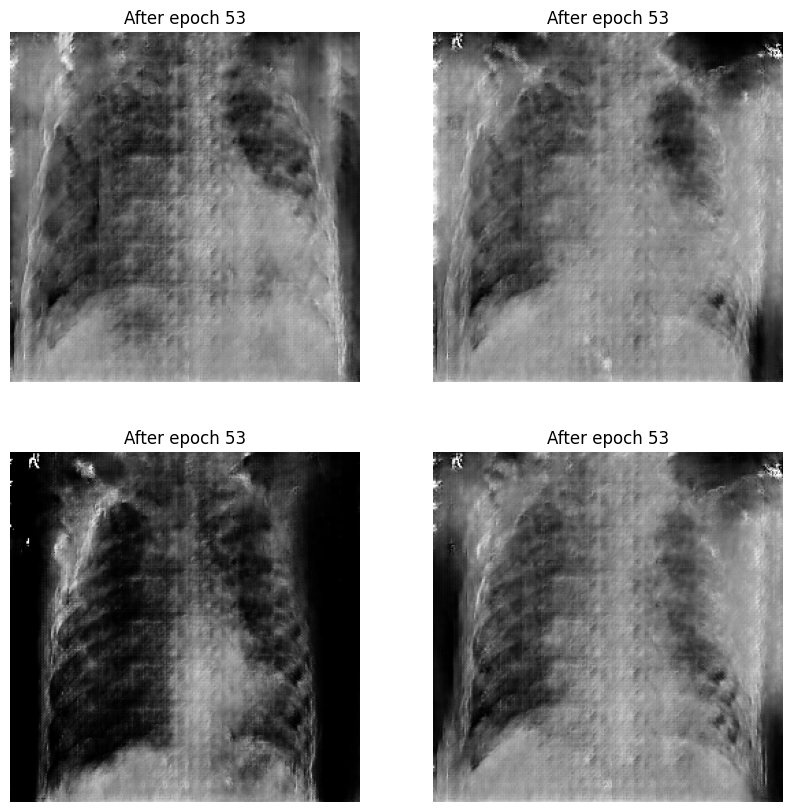

485/485 ━━━━━━━━━━━━━━━━━━━━ 109s 225ms/step - disc_loss: 0.0754 - gen_loss: 30.0267
Epoch 54/60
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - disc_loss: 0.0744 - gen_loss: 102.1749

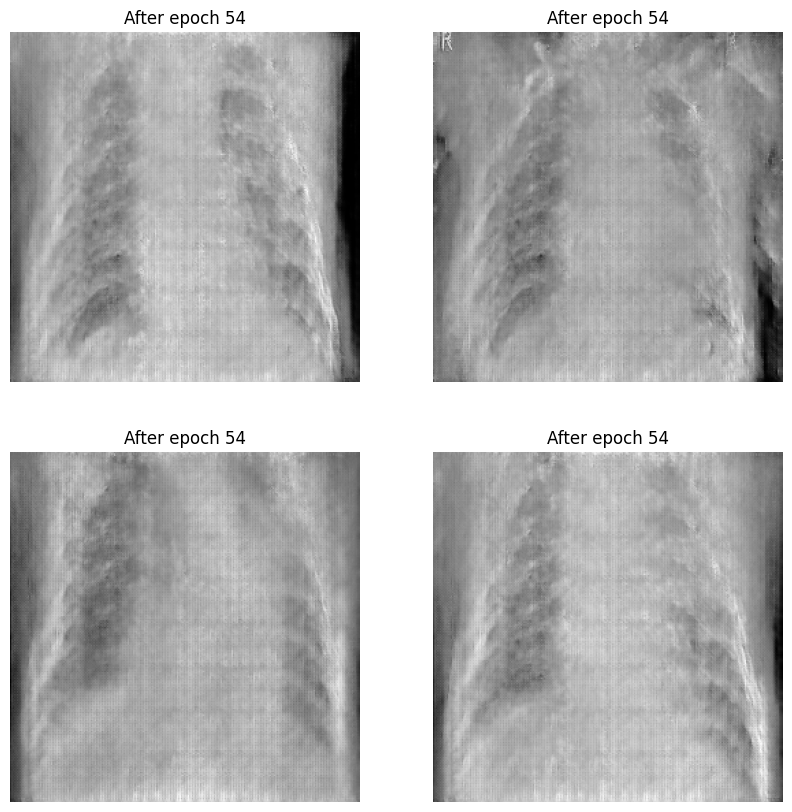

485/485 ━━━━━━━━━━━━━━━━━━━━ 109s 225ms/step - disc_loss: 0.0742 - gen_loss: 102.1718
Epoch 55/60
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - disc_loss: 0.2683 - gen_loss: 29.2106

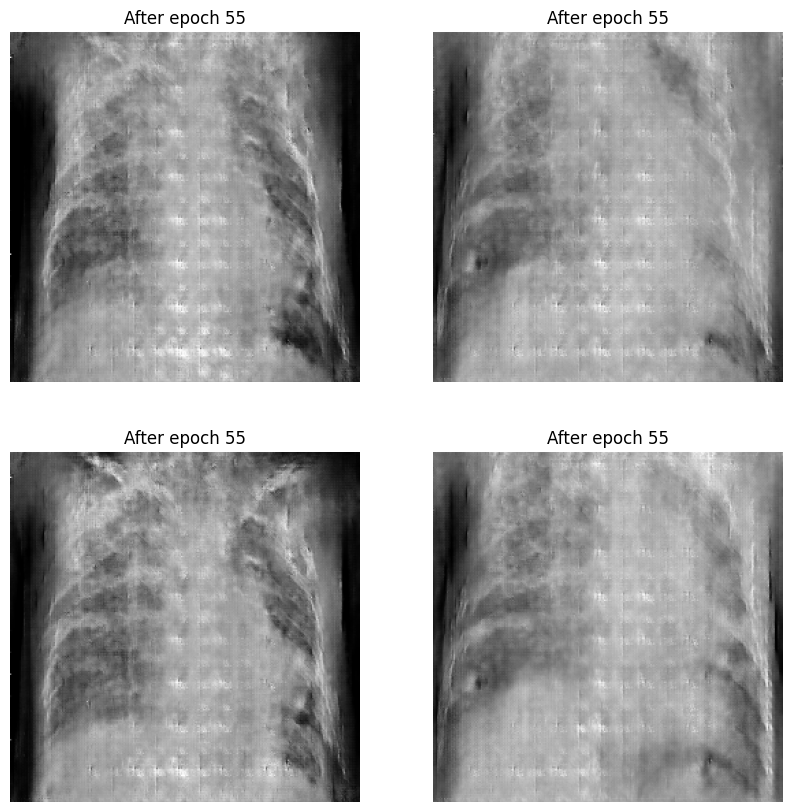

485/485 ━━━━━━━━━━━━━━━━━━━━ 109s 225ms/step - disc_loss: 0.2679 - gen_loss: 29.2030
Epoch 56/60
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - disc_loss: 0.1327 - gen_loss: 38.9937

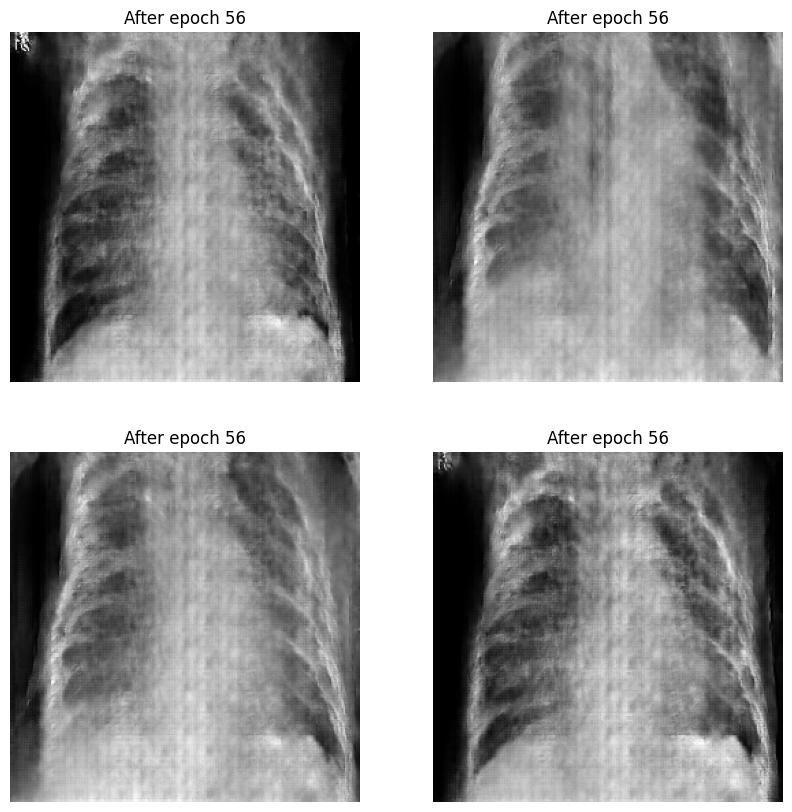

485/485 ━━━━━━━━━━━━━━━━━━━━ 109s 225ms/step - disc_loss: 0.1326 - gen_loss: 38.9791
Epoch 57/60
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - disc_loss: 0.0588 - gen_loss: 66.0806

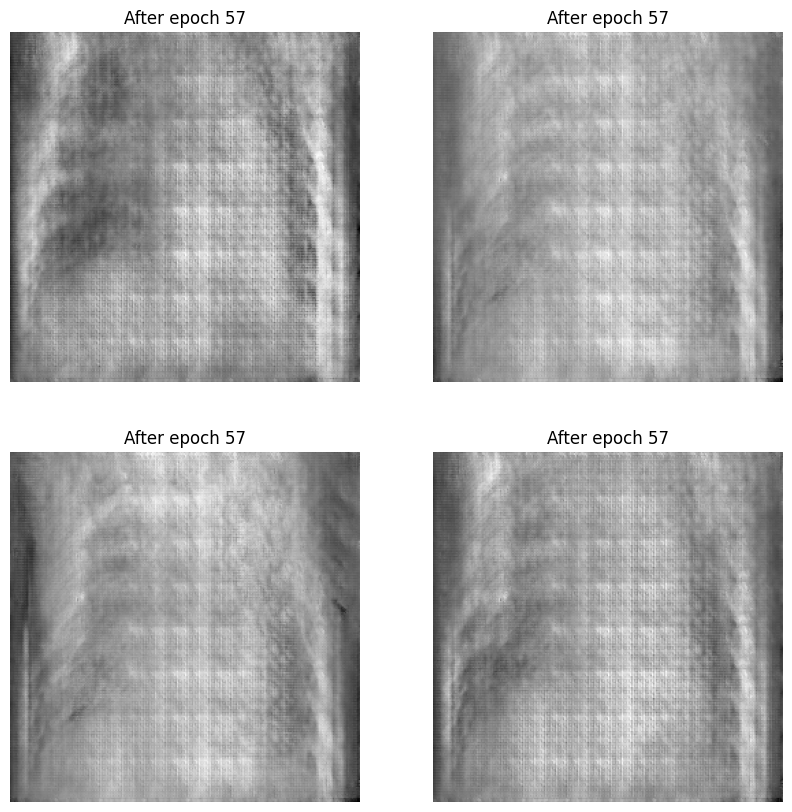

485/485 ━━━━━━━━━━━━━━━━━━━━ 109s 224ms/step - disc_loss: 0.0585 - gen_loss: 66.1826
Epoch 58/60
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - disc_loss: 0.3971 - gen_loss: 61.9429

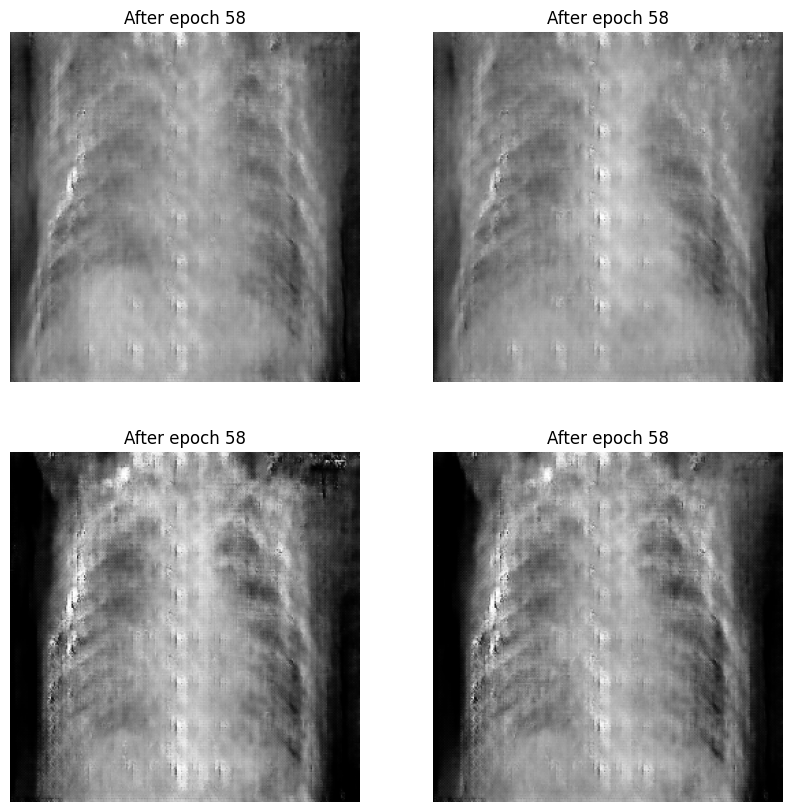

485/485 ━━━━━━━━━━━━━━━━━━━━ 109s 224ms/step - disc_loss: 0.3967 - gen_loss: 61.8915
Epoch 59/60
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - disc_loss: 0.0347 - gen_loss: 36.5621

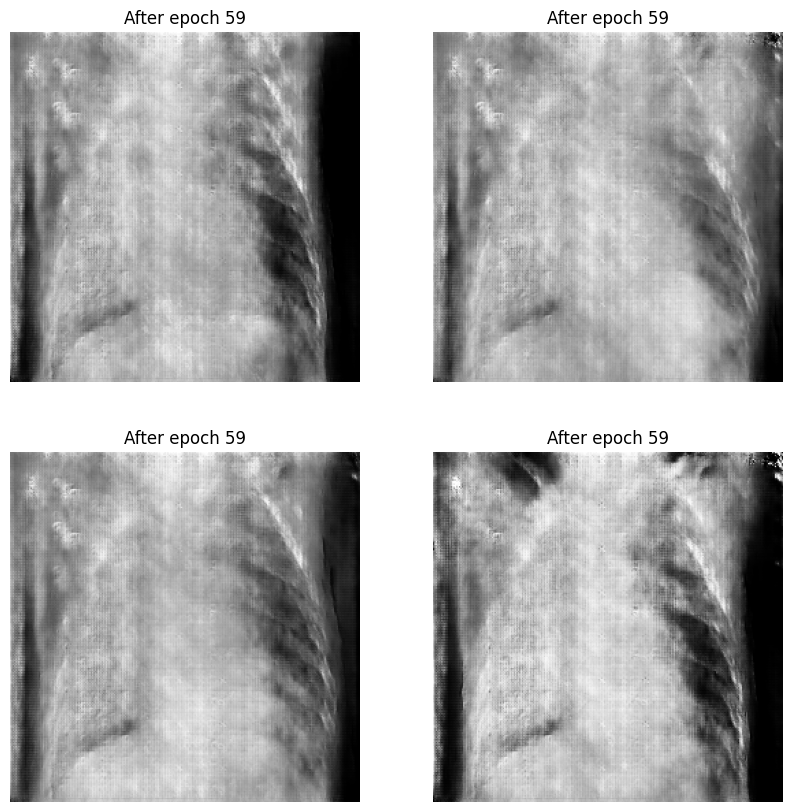

485/485 ━━━━━━━━━━━━━━━━━━━━ 109s 225ms/step - disc_loss: 0.0345 - gen_loss: 36.6140
Epoch 60/60
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - disc_loss: 0.5684 - gen_loss: 85.0402

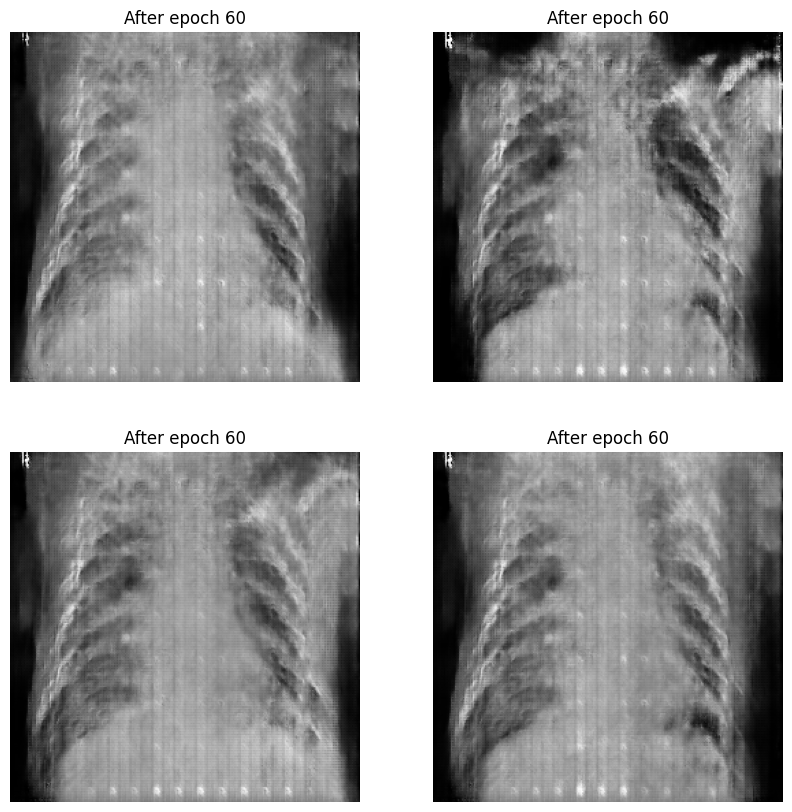

485/485 ━━━━━━━━━━━━━━━━━━━━ 109s 225ms/step - disc_loss: 0.5675 - gen_loss: 84.9887


In [131]:
# Actual training begins here..
history = gan.fit(
    image_loader(dataset),
    epochs=60, # Train for 10 more epochs (50 + 10)
    initial_epoch=50, # Start training from epoch 50
    steps_per_epoch=len(dataset),
    callbacks=[Gan_Callback(num_images=4, latent_dim=latent_dim)]
)